# 2026-01-13 Exploring Distance Distribution.ipynb
check how distances are distributed in the datasets we generated

In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

from refactor_training import npz_to_dataset

# Configure data directory - adjust as needed for your environment
# Uses TERRAIN_OUTPUT_DIR if set, otherwise falls back to common locations
OUTPUT_DIR = Path(os.environ.get('TERRAIN_OUTPUT_DIR', '/data/sam/terrain'))

# For cluster: /vast/projects/aribeiro/alelab/jporras/shortest-paths-nn
# For local: adjust to your data location
if not OUTPUT_DIR.exists():
    # Try alternative locations
    alternatives = [
        Path('/vast/projects/aribeiro/alelab/jporras/shortest-paths-nn'),
        Path.cwd().parent,  # repo root
    ]
    for alt in alternatives:
        if alt.exists():
            OUTPUT_DIR = alt
            break

print(f"Using OUTPUT_DIR: {OUTPUT_DIR}")

/home/jporras/miniconda3/envs/shortest-paths-nn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: jotaporras (alelab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using OUTPUT_DIR: /home/jporras/sourcecode/shortest-paths-nn


In [2]:
# Define resolutions to compare
resolutions = ['01', '40']

# Data structure to hold loaded data
data = {}

for res in resolutions:
    # Try generated2 first (smaller fractions), then generated (original)
    train_path = OUTPUT_DIR / 'data' / 'generated2' / f'res{res}_phase1.npz'
    if not train_path.exists():
        train_path = OUTPUT_DIR / 'data' / 'generated' / f'res{res}_phase1.npz'
    
    test_path = OUTPUT_DIR / 'data' / 'generated2' / 'full_test-001.npz'
    if not test_path.exists():
        test_path = OUTPUT_DIR / 'data' / 'generated' / 'full_test-001.npz'
    
    print(f"\n=== Resolution {res} ===")
    print(f"Train path: {train_path}")
    print(f"Test path: {test_path}")
    
    # Load train data
    if train_path.exists():
        train_data = np.load(train_path, allow_pickle=True)
        train_dataset, train_node_features, train_edge_index = npz_to_dataset(train_data)
        train_lengths = train_data['lengths']
        print(f"Train samples: {len(train_lengths)}, Nodes: {len(train_node_features)}")
        print(f"Train lengths - min: {train_lengths.min():.4f}, max: {train_lengths.max():.4f}, mean: {train_lengths.mean():.4f}")
    else:
        print(f"WARNING: Train file not found: {train_path}")
        train_lengths = None
    
    # Load test data
    if test_path.exists():
        test_data = np.load(test_path, allow_pickle=True)
        test_dataset, test_node_features, test_edge_index = npz_to_dataset(test_data)
        test_lengths = test_data['lengths']
        print(f"Test samples: {len(test_lengths)}, Nodes: {len(test_node_features)}")
        print(f"Test lengths - min: {test_lengths.min():.4f}, max: {test_lengths.max():.4f}, mean: {test_lengths.mean():.4f}")
    else:
        print(f"WARNING: Test file not found: {test_path}")
        test_lengths = None
    
    data[res] = {
        'train_lengths': train_lengths,
        'test_lengths': test_lengths,
    }


=== Resolution 01 ===
Train path: /home/jporras/sourcecode/shortest-paths-nn/data/generated2/res01_phase1.npz
Test path: /home/jporras/sourcecode/shortest-paths-nn/data/generated2/full_test-001.npz
Train samples: 50000, Nodes: 4000000
Train lengths - min: 0.1301, max: 28.7205, mean: 11.1621
Test samples: 200000000, Nodes: 4000000
Test lengths - min: 0.0000, max: 28.5423, mean: 11.2961

=== Resolution 40 ===
Train path: /home/jporras/sourcecode/shortest-paths-nn/data/generated2/res40_phase1.npz
Test path: /home/jporras/sourcecode/shortest-paths-nn/data/generated2/full_test-001.npz
Train samples: 50000, Nodes: 2500
Train lengths - min: 0.0000, max: 27.6070, mean: 7.9426
Test samples: 200000000, Nodes: 4000000
Test lengths - min: 0.0000, max: 28.5423, mean: 11.2961


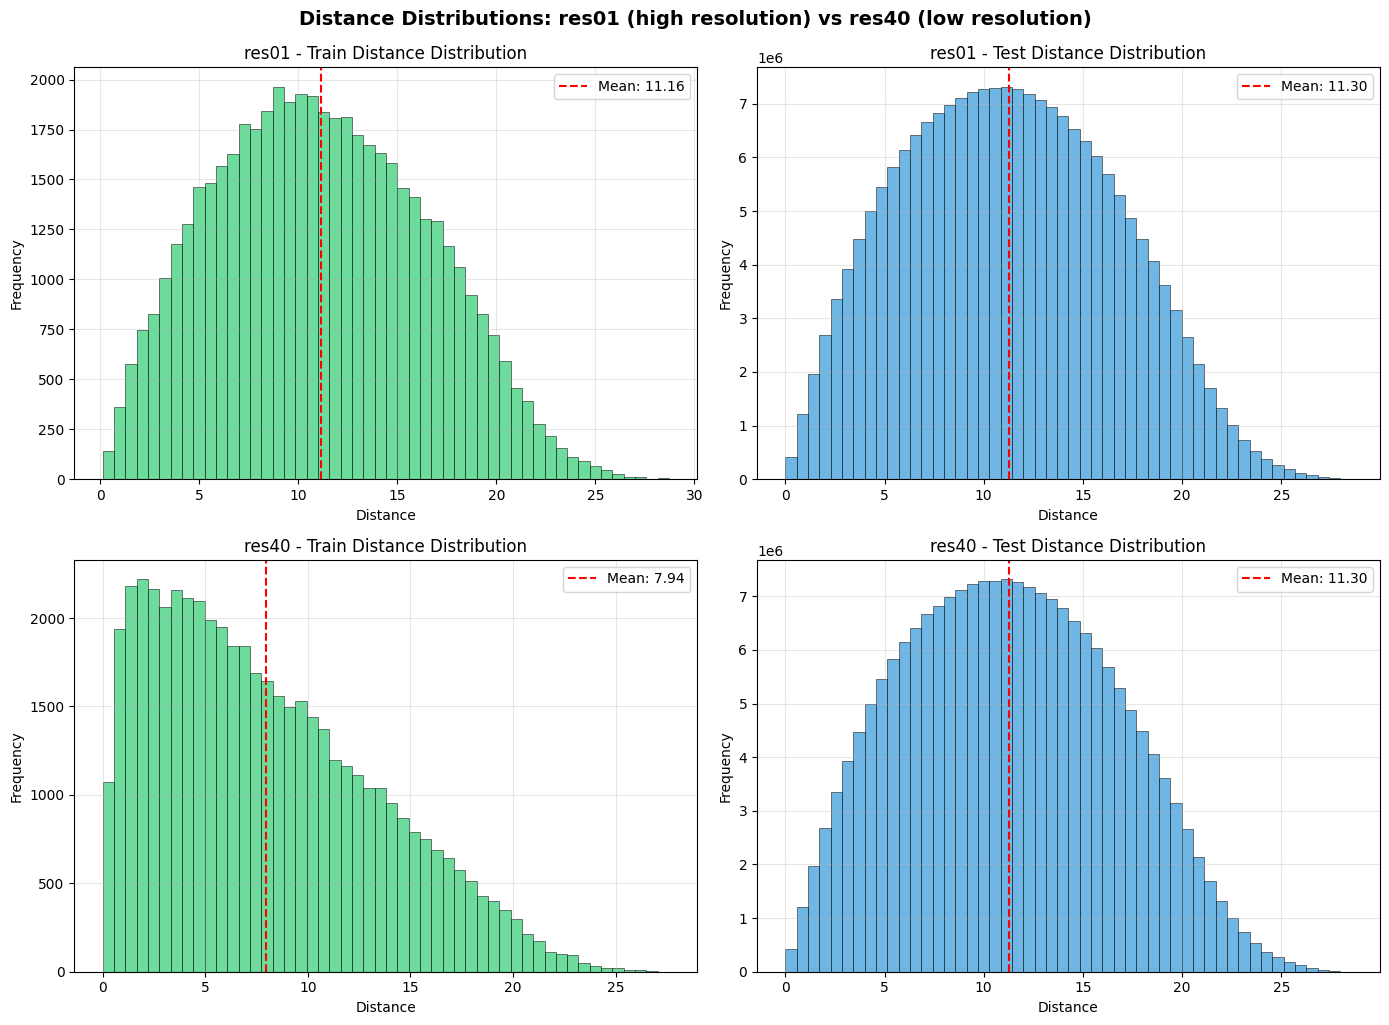

In [3]:
# Plot distance distributions for res01 and res40
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {'train': '#2ecc71', 'test': '#3498db'}
bins = 50

for i, res in enumerate(resolutions):
    res_data = data[res]
    
    # Train distribution
    ax_train = axes[i, 0]
    if res_data['train_lengths'] is not None:
        ax_train.hist(res_data['train_lengths'], bins=bins, color=colors['train'], 
                      alpha=0.7, edgecolor='black', linewidth=0.5)
        ax_train.axvline(res_data['train_lengths'].mean(), color='red', linestyle='--', 
                         label=f"Mean: {res_data['train_lengths'].mean():.2f}")
        ax_train.legend()
    ax_train.set_xlabel('Distance')
    ax_train.set_ylabel('Frequency')
    ax_train.set_title(f'res{res} - Train Distance Distribution')
    ax_train.grid(True, alpha=0.3)
    
    # Test distribution
    ax_test = axes[i, 1]
    if res_data['test_lengths'] is not None:
        ax_test.hist(res_data['test_lengths'], bins=bins, color=colors['test'], 
                     alpha=0.7, edgecolor='black', linewidth=0.5)
        ax_test.axvline(res_data['test_lengths'].mean(), color='red', linestyle='--', 
                        label=f"Mean: {res_data['test_lengths'].mean():.2f}")
        ax_test.legend()
    ax_test.set_xlabel('Distance')
    ax_test.set_ylabel('Frequency')
    ax_test.set_title(f'res{res} - Test Distance Distribution')
    ax_test.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Distance Distributions: res01 (high resolution) vs res40 (low resolution)', 
             y=1.02, fontsize=14, fontweight='bold')
plt.show()

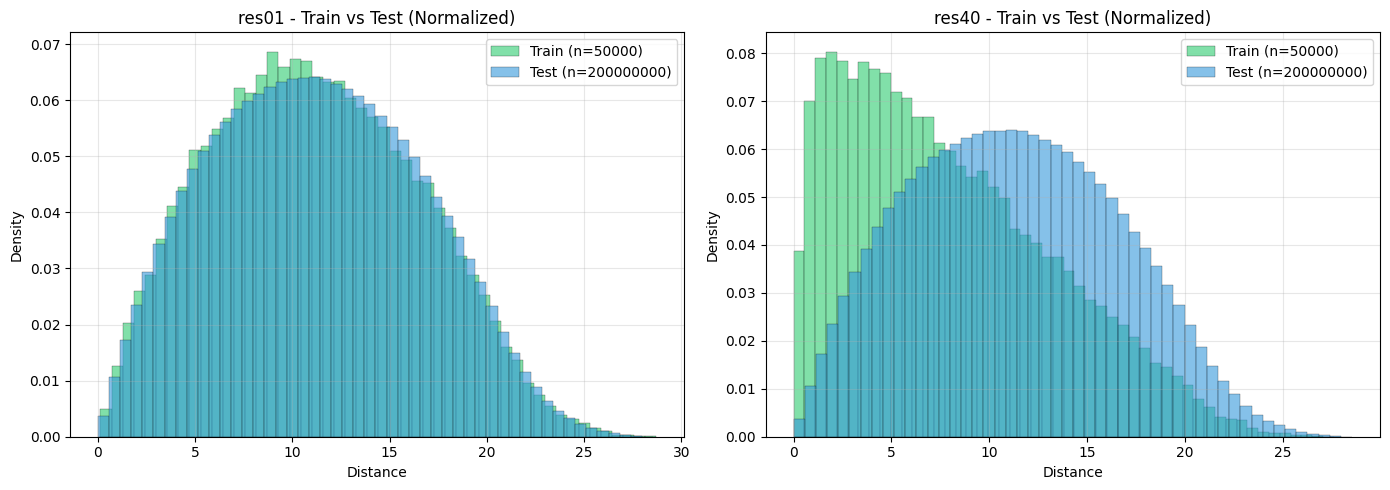

In [4]:
# Overlay comparison: Train vs Test for each resolution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, res in enumerate(resolutions):
    ax = axes[i]
    res_data = data[res]
    
    if res_data['train_lengths'] is not None:
        ax.hist(res_data['train_lengths'], bins=bins, color=colors['train'], 
                alpha=0.6, label=f'Train (n={len(res_data["train_lengths"])})', 
                density=True, edgecolor='black', linewidth=0.3)
    
    if res_data['test_lengths'] is not None:
        ax.hist(res_data['test_lengths'], bins=bins, color=colors['test'], 
                alpha=0.6, label=f'Test (n={len(res_data["test_lengths"])})', 
                density=True, edgecolor='black', linewidth=0.3)
    
    ax.set_xlabel('Distance')
    ax.set_ylabel('Density')
    ax.set_title(f'res{res} - Train vs Test (Normalized)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

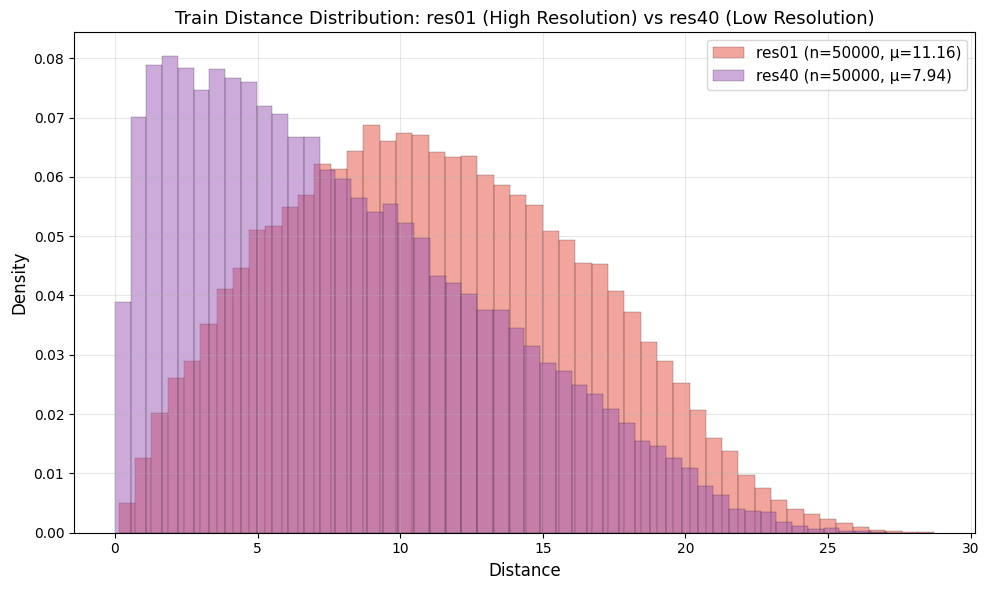

In [5]:
# Direct comparison: res01 vs res40 (Train only)
fig, ax = plt.subplots(figsize=(10, 6))

colors_res = {'01': '#e74c3c', '40': '#9b59b6'}

for res in resolutions:
    res_data = data[res]
    if res_data['train_lengths'] is not None:
        ax.hist(res_data['train_lengths'], bins=bins, color=colors_res[res], 
                alpha=0.5, label=f'res{res} (n={len(res_data["train_lengths"])}, μ={res_data["train_lengths"].mean():.2f})', 
                density=True, edgecolor='black', linewidth=0.3)

ax.set_xlabel('Distance', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Train Distance Distribution: res01 (High Resolution) vs res40 (Low Resolution)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Terrain Heatmap Visualization

This section visualizes the terrain as heatmaps:
1. **Full-size terrain heatmap** - from the original txt file
2. **Coarsened terrain heatmap** - from the generated npz file (any resolution)
3. **Heatmap with sample points** - full terrain overlaid with 500 source points from the dataset

In [6]:
# =============================================================================
# INPUT VARIABLES - Modify these to change the visualization
# =============================================================================

# DATASET_NAME: either "philadelphia" or "norway"
# Maps to: philadelphia -> flat-phil-data-1.txt, norway -> norway-smallest.txt
DATASET_NAME = "norway"

# GENERATED_DATASET_PATH: path to the generated npz file (any resolution)
# Examples: 
#   - "data/generated/res01_phase1.npz" (full resolution)
#   - "data/generated/res10_phase1.npz" (coarsened)
#   - "data/generated/res40_phase1.npz" (heavily coarsened)
#   - "data/generated/full_test-001.npz" (test set)
GENERATED_DATASET_PATH = "data/generated/res40_phase1.npz"

In [7]:
# Mapping from dataset name to txt file
DATASET_NAME_TO_FILE = {
    "philadelphia": "flat-phil-data-1.txt",
    "norway": "norway-smallest.txt",
    "holland": "holland-new.txt",
}

def load_terrain_from_txt(txt_path):
    """
    Load terrain data from a txt file.
    
    Parameters:
    -----------
    txt_path : str or Path
        Path to the .txt terrain file
    
    Returns:
    --------
    terrain : np.ndarray
        2D array of height values (rows x cols)
    rows : int
        Number of rows
    cols : int  
        Number of columns
    """
    with open(txt_path, 'r') as f:
        first_line = f.readline().strip()
        rows, cols = map(int, first_line.split())
        
        terrain = []
        for line in f:
            row_values = list(map(float, line.strip().split()))
            terrain.append(row_values)
    
    terrain = np.array(terrain)
    return terrain, rows, cols


def load_coarsened_terrain_from_npz(npz_path):
    """
    Load node features from npz file and extract terrain info.
    
    Parameters:
    -----------
    npz_path : str or Path
        Path to the .npz file
    
    Returns:
    --------
    node_features : np.ndarray
        Node features (x, y, z coordinates)
    srcs : np.ndarray
        Source node indices
    tars : np.ndarray
        Target node indices
    """
    data = np.load(npz_path, allow_pickle=True)
    node_features = data['node_features']
    srcs = data['srcs']
    tars = data['tars']
    return node_features, srcs, tars


def infer_grid_size(num_nodes):
    """
    Infer grid dimensions from number of nodes.
    Assumes square or near-square grid.
    """
    sqrt_n = int(np.sqrt(num_nodes))
    if sqrt_n * sqrt_n == num_nodes:
        return sqrt_n, sqrt_n
    # Try to find factors close to sqrt
    for i in range(sqrt_n, 0, -1):
        if num_nodes % i == 0:
            return i, num_nodes // i
    return sqrt_n, sqrt_n  # fallback

In [8]:
# Load the data based on input variables
data_dir = Path('../data')

# Load full-size terrain from txt file
txt_filename = DATASET_NAME_TO_FILE.get(DATASET_NAME.lower())
if txt_filename is None:
    raise ValueError(f"Unknown dataset name: {DATASET_NAME}. Use one of: {list(DATASET_NAME_TO_FILE.keys())}")

txt_path = data_dir / txt_filename
print(f"Loading full terrain from: {txt_path}")
terrain_full, rows, cols = load_terrain_from_txt(txt_path)
print(f"  Dimensions: {rows} x {cols} = {rows * cols:,} nodes")
print(f"  Height range: [{terrain_full.min():.2f}, {terrain_full.max():.2f}]")

# Load coarsened terrain from npz file
npz_path = Path('..') / GENERATED_DATASET_PATH
print(f"\nLoading generated dataset from: {npz_path}")
node_features_coarse, srcs, tars = load_coarsened_terrain_from_npz(npz_path)
num_nodes_coarse = len(node_features_coarse)
grid_rows, grid_cols = infer_grid_size(num_nodes_coarse)
print(f"  Nodes: {num_nodes_coarse:,} (inferred grid: {grid_rows} x {grid_cols})")
print(f"  Sample pairs: {len(srcs):,}")

# Reshape coarsened node features to grid for heatmap
# node_features has shape (N, 3) with columns (x, y, z)
# z is the height, we need to reshape based on x, y coordinates
x_coords = node_features_coarse[:, 0]
y_coords = node_features_coarse[:, 1]
z_coords = node_features_coarse[:, 2]
print(f"  Height range: [{z_coords.min():.2f}, {z_coords.max():.2f}]")

Loading full terrain from: ../data/norway-smallest.txt
  Dimensions: 2000 x 2000 = 4,000,000 nodes
  Height range: [899.70, 2316.50]

Loading generated dataset from: ../data/generated/res40_phase1.npz
  Nodes: 2,500 (inferred grid: 50 x 50)
  Sample pairs: 50,000
  Height range: [0.92, 2.27]


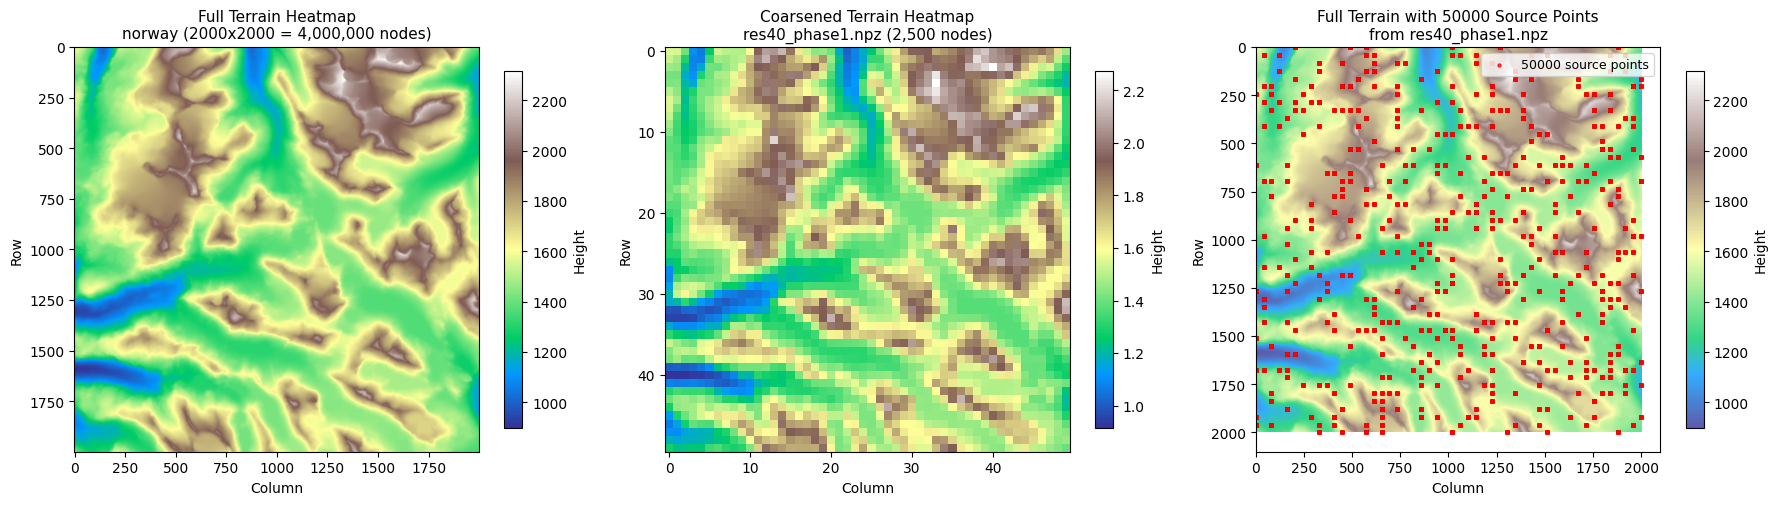


Summary:
  Dataset: norway (norway-smallest.txt)
  Full terrain: 2000 x 2000 = 4,000,000 nodes
  Coarsened terrain: 2,500 nodes
  Source points shown: 50000


In [12]:
# Create the three plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Common colormap for terrain
cmap = 'terrain'

# =============================================================================
# Plot 1: Full-size terrain heatmap (from txt file)
# =============================================================================
ax1 = axes[0]
im1 = ax1.imshow(terrain_full, cmap=cmap, aspect='equal')
ax1.set_title(f'Full Terrain Heatmap\n{DATASET_NAME} ({rows}x{cols} = {rows*cols:,} nodes)', fontsize=11)
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
plt.colorbar(im1, ax=ax1, label='Height', shrink=0.8)

# =============================================================================
# Plot 2: Coarsened terrain heatmap (from npz file)
# =============================================================================
ax2 = axes[1]

# Try to reshape into grid based on sorted coordinates
# Sort by y (row) then x (col) to get grid ordering
sort_idx = np.lexsort((x_coords, y_coords))
z_sorted = z_coords[sort_idx]

# Reshape to grid
try:
    terrain_coarse = z_sorted.reshape(grid_rows, grid_cols)
    im2 = ax2.imshow(terrain_coarse, cmap=cmap, aspect='equal')
except ValueError:
    # If reshape fails, use scatter plot instead
    scatter = ax2.scatter(x_coords, y_coords, c=z_coords, cmap=cmap, s=1)
    im2 = scatter

ax2.set_title(f'Coarsened Terrain Heatmap\n{Path(GENERATED_DATASET_PATH).name} ({num_nodes_coarse:,} nodes)', fontsize=11)
ax2.set_xlabel('Column' if grid_rows * grid_cols == num_nodes_coarse else 'X')
ax2.set_ylabel('Row' if grid_rows * grid_cols == num_nodes_coarse else 'Y')
plt.colorbar(im2, ax=ax2, label='Height', shrink=0.8)

# =============================================================================
# Plot 3: Full terrain with 500 source points overlaid
# =============================================================================
ax3 = axes[2]
im3 = ax3.imshow(terrain_full, cmap=cmap, aspect='equal', alpha=0.8)

# Sample 500 source points (or all if fewer than 500)
#n_points = min(500, len(srcs))
n_points = len(srcs)
np.random.seed(42)  # For reproducibility
sample_idx = np.random.choice(len(srcs), size=n_points, replace=False)
sample_srcs = srcs[sample_idx]

# Get x, y coordinates of source points
# Need to scale from coarse grid coordinates to full grid coordinates
src_x = x_coords[sample_srcs]
src_y = y_coords[sample_srcs]

# Scale coordinates to full terrain dimensions
# Assuming coordinates are normalized or need scaling
x_scale = cols / (x_coords.max() - x_coords.min() + 1e-8)
y_scale = rows / (y_coords.max() - y_coords.min() + 1e-8)

src_x_scaled = (src_x - x_coords.min()) * x_scale
src_y_scaled = (src_y - y_coords.min()) * y_scale

# Plot source points
ax3.scatter(src_x_scaled, src_y_scaled, c='red', s=5, alpha=0.7, label=f'{n_points} source points')
ax3.set_title(f'Full Terrain with {n_points} Source Points\nfrom {Path(GENERATED_DATASET_PATH).name}', fontsize=11)
ax3.set_xlabel('Column')
ax3.set_ylabel('Row')
ax3.legend(loc='upper right', fontsize=9)
plt.colorbar(im3, ax=ax3, label='Height', shrink=0.8)

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Dataset: {DATASET_NAME} ({txt_filename})")
print(f"  Full terrain: {rows} x {cols} = {rows*cols:,} nodes")
print(f"  Coarsened terrain: {num_nodes_coarse:,} nodes")
print(f"  Source points shown: {n_points}")

### Optional: Individual Larger Plots

Uncomment and run sections below for larger individual plots.

### Source-Target Pairs Visualization

Plot source-target pairs as lines connecting the points on the terrain.

In [18]:
# Number of pairs to plot (adjust as needed)
#N_PAIRS = 500
#N_PAIRS = len(srcs)
N_PAIRS = 1000

# Sample pairs
np.random.seed(42)
n_pairs_to_plot = min(N_PAIRS, len(srcs))
pair_idx = np.random.choice(len(srcs), size=n_pairs_to_plot, replace=False)

# Get source and target coordinates
pair_srcs = srcs[pair_idx]
pair_tars = tars[pair_idx]

# Source coordinates
src_x_pairs = x_coords[pair_srcs]
src_y_pairs = y_coords[pair_srcs]

# Target coordinates  
tar_x_pairs = x_coords[pair_tars]
tar_y_pairs = y_coords[pair_tars]

# Scale to full terrain dimensions
src_x_pairs_scaled = (src_x_pairs - x_coords.min()) * x_scale
src_y_pairs_scaled = (src_y_pairs - y_coords.min()) * y_scale
tar_x_pairs_scaled = (tar_x_pairs - x_coords.min()) * x_scale
tar_y_pairs_scaled = (tar_y_pairs - y_coords.min()) * y_scale

print(f"Plotting {n_pairs_to_plot} source-target pairs")

Plotting 1000 source-target pairs


In [19]:
# # Larger full terrain heatmap
# fig, ax = plt.subplots(figsize=(10, 10))
# im = ax.imshow(terrain_full, cmap='terrain', aspect='equal')
# ax.set_title(f'Full Terrain: {DATASET_NAME} ({rows}x{cols})', fontsize=14)
# ax.set_xlabel('Column')
# ax.set_ylabel('Row')
# plt.colorbar(im, ax=ax, label='Height')
# plt.tight_layout()
# plt.show()

# # Larger coarsened terrain heatmap
# fig, ax = plt.subplots(figsize=(10, 10))
# try:
#     im = ax.imshow(terrain_coarse, cmap='terrain', aspect='equal')
# except:
#     im = ax.scatter(x_coords, y_coords, c=z_coords, cmap='terrain', s=2)
# ax.set_title(f'Coarsened Terrain: {Path(GENERATED_DATASET_PATH).name}', fontsize=14)
# plt.colorbar(im, ax=ax, label='Height')
# plt.tight_layout()
# plt.show()

# # Larger terrain with points overlay
# fig, ax = plt.subplots(figsize=(12, 12))
# im = ax.imshow(terrain_full, cmap='terrain', aspect='equal', alpha=0.8)
# ax.scatter(src_x_scaled, src_y_scaled, c='red', s=10, alpha=0.6, edgecolors='darkred', linewidths=0.5)
# ax.set_title(f'Terrain with {n_points} Source Points', fontsize=14)
# ax.set_xlabel('Column')
# ax.set_ylabel('Row')
# plt.colorbar(im, ax=ax, label='Height')
# plt.tight_layout()
# plt.show()

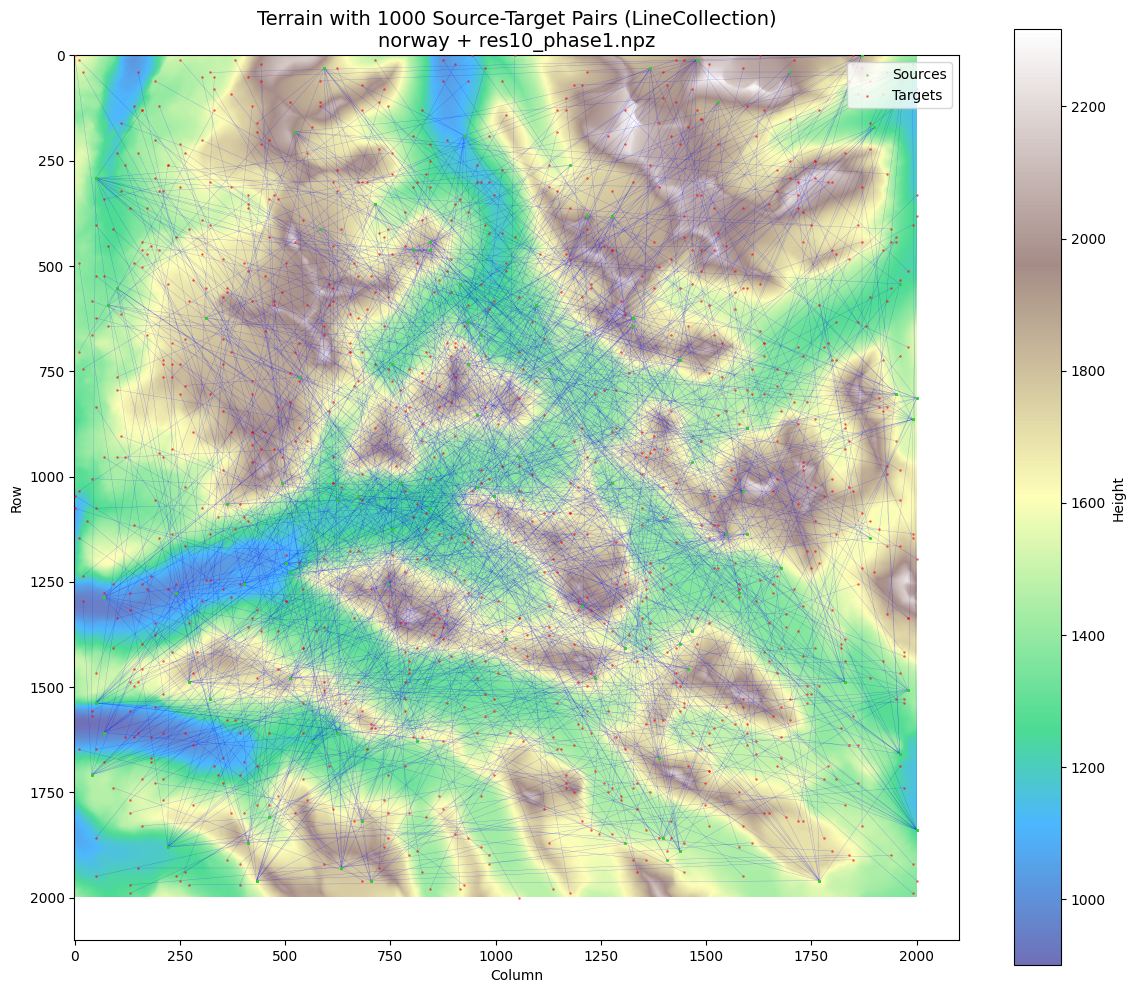

In [ ]:
# Alternative: Using LineCollection for better performance with many lines
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(figsize=(12, 12))

# Plot terrain heatmap
im = ax.imshow(terrain_full, cmap='terrain', aspect='equal', alpha=0.7)

# Create line segments for all pairs
segments = [
    [(src_x_pairs_scaled[i], src_y_pairs_scaled[i]), 
     (tar_x_pairs_scaled[i], tar_y_pairs_scaled[i])]
    for i in range(n_pairs_to_plot)
]

# Use LineCollection for efficient rendering
lc = LineCollection(segments, colors='blue', alpha=0.4, linewidths=0.2)
ax.add_collection(lc)

# Plot source points (green) and target points (red)
ax.scatter(src_x_pairs_scaled, src_y_pairs_scaled, c='limegreen', s=3, alpha=0.65, 
           label='Sources', zorder=5, edgecolors='darkgreen', linewidths=0.001)
ax.scatter(tar_x_pairs_scaled, tar_y_pairs_scaled, c='red', s=3, alpha=0.65, 
           label='Targets', zorder=5, edgecolors='darkred', linewidths=0.001)

ax.set_title(f'Terrain with {n_pairs_to_plot} Source-Target Pairs (LineCollection)\n{DATASET_NAME} + {Path(GENERATED_DATASET_PATH).name}', fontsize=14)
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.legend(loc='upper right', fontsize=10)
plt.colorbar(im, ax=ax, label='Height', shrink=0.8)

plt.tight_layout()
plt.show()